In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

In [2]:
gym.logger.set_level(40)

In [3]:
ENV_NAME = 'CartPole-v0'
input_dim = 4
action_list = [0,1]

In [4]:
class A3C(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.fc4 = nn.Linear(128, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        Q = self.fc3(x)
        V = self.fc4(x)
        return Q, V
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [5]:
NUM_THREADS = 8

#T_max = 10000
MAX_EP = 20000
t_max = 5
print_freq = 1000

beta = 0.01   # entropy regularization
gamma = 0.99
alpha = 0.99   # RMSProb decay factor
learning_rate = 1e-4
decay_rate = 0.996

In [6]:
def train(lock, globalNet, optimizer, tmax, pid):
    t = 0
    done = False
    ep_return = 0
    log_episode_return = []
    cur_ep = 0
    
    localNet = A3C(input_dim, len(action_list))
    localNet.load_state_dict(globalNet.state_dict())
    env = gym.make(ENV_NAME)
    obs = env.reset()
    
    while globalNet.ep_counter.value < MAX_EP:
        t_start = t
        buff_value = []
        buff_q = []
        buff_reward = []
        buff_logp = []
        buff_entropy = []

        while t_start-t < t_max:
            Q, V = localNet(torch.tensor(obs.astype(np.float32)))
            prob = F.softmax(Q, dim=0).data
            [a] = np.random.choice(localNet.action_dim, 1, p=prob.detach().numpy())
            log_prob = F.log_softmax(Q, dim=0)

            obs, reward, done, _ = env.step(action_list[a])
            ep_return += reward
            entropy = -log_prob*prob.sum()

            buff_q.append(Q)
            buff_value.append(V)
            buff_reward.append(reward)
            buff_logp.append(log_prob[a])
            buff_entropy.append(entropy)
            t += 1
            
            if done:
                cur_ep = globalNet.log_episode(ep_return)
                obs = env.reset()
                ep_return = 0
                break

        R = V if not done else 0
        policy_loss = 0
        value_loss = 0
        entropy_loss = 0
        for i in range(-1, -(t-t_start)-1, -1): #range(t-1, t_start-1, -1):
            R = buff_reward[i] + gamma*R
            TD = R - buff_value[i]
            policy_loss += buff_logp[i] * TD.detach()
            value_loss += torch.pow(TD, 2)
            entropy_loss += buff_entropy[i].sum()
        loss = - policy_loss + value_loss - beta*entropy_loss
        
        optimizer.zero_grad()
        loss.backward()
        lock.acquire()
        try:
            for local_param, global_param in zip(localNet.parameters(), globalNet.parameters()):
                global_param.grad = local_param.grad
            optimizer.step()
        finally:
            lock.release()
        localNet.load_state_dict(globalNet.state_dict())
        
        if cur_ep%print_freq==0: #globalNet.ep_counter.value%100==0:
            print('[%d] Process'%pid)
            print('%d/%d episodes. (%.2f%%)'%(cur_ep, MAX_EP, cur_ep/MAX_EP*100))
            #print(globalNet.ep_counter.value-1, 'episodes.')
            print('Total loss:\t', loss.data.numpy()[0])
            print('Entropy\t\tPolicy\t\tValue')
            print('%.2f\t\t%.2f\t\t%.2f'%(entropy_loss.data.numpy(), policy_loss.data.numpy()[0], \
                  value_loss.data.numpy()[0]))
            print('Epside Return: [%.1f]'%globalNet.average_returns[globalNet.ep_counter.value-1])
            print()

In [7]:
globalNet = A3C(input_dim, len(action_list), MAX_EP, is_global=True)
globalNet.share_memory()
optimizer = optim.Adam(globalNet.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
lock = mp.Lock()

processes = []
for p_idx in range(NUM_THREADS):
    p = mp.Process(target=train, args=(lock, globalNet, optimizer, t_max, p_idx))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

[7] Process
1000/20000 episodes. (5.00%)
Total loss:	 316.10135
Entropy		Policy		Value
16.90		31.52		347.79
Epside Return: [23.0]

[6] Process
2000/20000 episodes. (10.00%)
Total loss:	 1691.066
Entropy		Policy		Value
20.46		100.65		1791.92
Epside Return: [39.4]

[7] Process
3000/20000 episodes. (15.00%)
Total loss:	 66832.414
Entropy		Policy		Value
182.72		-921.90		65912.34
Epside Return: [60.9]

[5] Process
4000/20000 episodes. (20.00%)
Total loss:	 20088.496
Entropy		Policy		Value
54.18		478.95		20567.99
Epside Return: [76.7]

[5] Process
5000/20000 episodes. (25.00%)
Total loss:	 48536.527
Entropy		Policy		Value
134.23		927.28		49465.15
Epside Return: [126.0]

[1] Process
6000/20000 episodes. (30.00%)
Total loss:	 88210.85
Entropy		Policy		Value
342.09		785.40		88999.67
Epside Return: [185.2]

[3] Process
7000/20000 episodes. (35.00%)
Total loss:	 155779.7
Entropy		Policy		Value
326.52		1830.36		157613.33
Epside Return: [167.7]

[6] Process
8000/20000 episodes. (40.00%)
Total loss:

Process Process-4:
Traceback (most recent call last):
  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-3767d3ec2b47>", line 39, in train
    cur_ep = globalNet.log_episode(ep_return)
  File "<ipython-input-4-9ecde70b7fe2>", line 35, in log_episode
    self.ep_returns[c] = ep_return
  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/sharedctypes.py", line 226, in __setitem__
    self._obj[i] = value
IndexError: invalid index
Process Process-2:
Traceback (most recent call last):
  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


[7] Process


  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


20000/20000 episodes. (100.00%)


  File "<ipython-input-6-3767d3ec2b47>", line 39, in train
    cur_ep = globalNet.log_episode(ep_return)


Total loss:	 102835.64


  File "<ipython-input-4-9ecde70b7fe2>", line 35, in log_episode
    self.ep_returns[c] = ep_return


Entropy		Policy		Value


  File "/home/gun/anaconda3/envs/py3_cpu/lib/python3.6/multiprocessing/sharedctypes.py", line 226, in __setitem__
    self._obj[i] = value


78.80		1260.90		104097.33


IndexError: invalid index


Epside Return: [130.1]



## No Learning Rate Decay

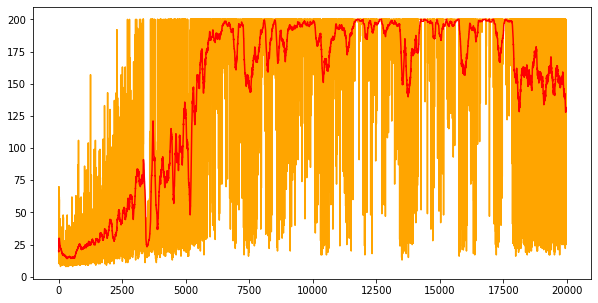

In [9]:
plt.figure(figsize=(10, 5))
average_returns = np.array(globalNet.average_returns[:])
ep_returns = np.array(globalNet.ep_returns[:])
nonzero_indices = average_returns!=0.0
plt.plot(ep_returns[nonzero_indices], color='orange')
plt.plot(average_returns[nonzero_indices], color='red')
fignum = len([f for f in os.listdir() if 'CartPole' in f and 'png' in f])
plt.savefig('A3C_CartPole_%d.png'%fignum)